In [12]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import multiprocessing
from multiprocessing import Pool
from functools import partial
from tqdm.notebook import tqdm
from choldate import cholupdate
from pycss.CSS import *
from pycss.subset_selection import *
from pycss.model_selection import *
from notebook_utils.utils import * 
from notebook_utils.data_generation import * 
from notebook_utils.missing_data import *
from matplotlib import pyplot as plt

In [2]:
#def get_rel_error(W_hat, W):
#    return np.linalg.norm(W_hat - W)/np.linalg.norm(W)

def get_regression_coeffs(Sigma, S):
    return Sigma[complement(p, S), :][:, S] @ np.linalg.inv(Sigma[S, :][:, S])

def Sigma_MLE_from_MLE(MLE):
    
    noise = noise_from_MLE(MLE)
    p = np.sum(MLE['W_MLE'].shape)
    k = len(MLE['S_MLE'])
    
    Sigma_MLE = np.zeros((p, p))
    Sigma_MLE[:k, :k] = MLE['C_MLE'].copy()
    Sigma_MLE[k:, :k] = MLE['W_MLE'] @ MLE['C_MLE']
    Sigma_MLE[:k, k:] = Sigma_MLE[k:, :k].T.copy()
    Sigma_MLE[k:, k:] =  MLE['W_MLE'] @ MLE['C_MLE'] @ MLE['W_MLE'].T
    if noise == 'sph':
        np.fill_diagonal(Sigma_MLE[k:, k:], np.diag(Sigma_MLE[k:, k:]) + MLE['sigma_sq_MLE'])
    if noise == 'diag':
        np.fill_diagonal(Sigma_MLE[k:, k:], np.diag(Sigma_MLE[k:, k:]) + MLE['D_MLE'])
    perm_in_place(Sigma_MLE, np.concatenate([MLE['S_MLE'], complement(p, MLE['S_MLE'])]), np.arange(p))
    
    return Sigma_MLE

def get_test_reconstruction_error(Sigma, S_hat, W_hat, mu_hat, mu=None):
    if mu is None:
        mu = np.zeros(len(mu_hat))
    S_hat_comp = complement(p, S_hat)
    return np.trace(Sigma[S_hat_comp, :][:, S_hat_comp]) + np.trace(W_hat @ Sigma[S_hat, :][:, S_hat] @ W_hat.T) - 2*np.trace(W_hat @  Sigma[S_hat, :][:, S_hat_comp]) + np.sum(np.square(mu[S_hat_comp] - mu_hat[S_hat_comp] - W_hat @ (mu[S_hat] - mu_hat[S_hat])) )
    

# Synthetic Data Experiment

In [3]:
p = 20
k = 4
C_chol = get_equicorrelated_chol(k, 0.25, diag=1)
C = C_chol @ C_chol.T
sigma_sq = 0.2
    
W = get_block_W(p, k, num_blocks=2, block_size=3, overlap=2)

#np.random.seed(0)
#W *= np.random.choice(np.array([-1, 1]), W.shape)

signs = np.array([[1, 1, 1, 0], 
                  [1, 1, -1, 0], 
                  [1, -1, 1, 0], 
                  [1, -1, -1, 0], 
                  [-1, 1, 1, 0],
                  [-1, 1, -1, 0], 
                  [-1, -1, 1, 0],
                  [-1, -1, -1, 0],
                  [0, 1, 1, 1], 
                  [0, 1, 1, -1], 
                  [0, 1, -1, 1], 
                  [0, 1, -1, -1], 
                  [0, -1, 1, 1],
                  [0, -1, 1, -1], 
                  [0, -1, -1, 1],
                  [0, -1, -1, -1]])

W *= signs
signal_sizes = np.sum(W * (W @ C), axis=1)
W = np.sqrt(1 - sigma_sq)/np.sqrt(signal_sizes)[:, None] * W

MLE = {'C_MLE': C,
       'W_MLE': W,
       'sigma_sq_MLE': sigma_sq,
       'S_MLE': np.arange(k)}

Sigma = Sigma_MLE_from_MLE(MLE)

B = 1000
n=50
num_inits=1
noise = 'sph'
q = 0.05

In [5]:
X = generate_gaussian_PCSS_data(n, W=W, C_chol=C_chol, sigma_sq=sigma_sq, B=B)
#X_orig = X.copy()
X[np.where(np.random.binomial(1, q, X.shape))] = np.nan
#X_c = X - np.nanmean(X, axis=1)[:, np.newaxis, :]

### Mean Imputation

In [6]:
missing_data_search = partial(mean_imputation_css_with_missing_data, k=k, num_inits=num_inits)
with Pool(multiprocessing.cpu_count()) as pool:
    results = [result for result in tqdm(pool.imap_unordered(missing_data_search, list(X)))]
    

0it [00:00, ?it/s]

In [7]:
S_correct = 0 
test_error = np.zeros(B)

for i, result in enumerate(results):
    
    S = result[0]
    coeff_hat = result[1]
    converged = result[2]
    
    if not converged:
        print("iteration " + str(i) + " did not converge.")
    
    if np.all(set(S) == set(np.arange(k))):
        S_correct += 1
    
    X_i = X[i, :, :]
    X_filled = np.where(np.isnan(X_i), np.nanmean(X_i, axis=0), X_i)
    mu_hat, Sigma_hat = get_moments(X_filled)
    test_error[i] = get_test_reconstruction_error(Sigma, S, coeff_hat, mu_hat)
    
print(S_correct/B)
print(np.mean(test_error)/(sigma_sq * (p-k)))

0.694
1.3338412860581819


### EM Algorithm

In [8]:
missing_data_search = partial(pcss_with_missing_data, k=k, num_inits=num_inits)
with Pool(multiprocessing.cpu_count()) as pool:
    results = [result for result in tqdm(pool.imap_unordered(missing_data_search, list(X)))]
    

0it [00:00, ?it/s]

In [9]:
S_correct = 0 
test_error = np.zeros(B)

for i, result in enumerate(results):
    
    S = result[0]
    coeff_hat = result[1]
    converged = result[2]
    
    if not converged:
        print("iteration " + str(i) + " did not converge.")
    
    if np.all(set(S) == set(np.arange(k))):
        S_correct += 1
    
    test_error[i] = get_test_reconstruction_error(Sigma, S, coeff_hat, result[3]) # the mean is cheating!

print(S_correct/B)
print(np.mean(test_error)/(sigma_sq * (p-k)))

0.97
1.14048724442999


### Masked Covariance

In [30]:
missing_data_search = partial(masked_css_with_missing_data, k=k, num_inits=num_inits, method='swap')
with Pool(multiprocessing.cpu_count()) as pool:
    results = [result for result in tqdm(pool.imap_unordered(missing_data_search, list(X)))]
    

0it [00:00, ?it/s]

In [31]:
S_correct = 0 
CSS_error = np.zeros(B)
test_error = np.zeros(B)

for i, result in enumerate(results):
    
    S = result[0]
    coeff_hat = result[1]
    converged = result[2]
    
    if not converged:
        print("iteration " + str(i) + " did not converge.")
    
    if np.all(set(S) == set(np.arange(k))):
        S_correct += 1
    
    CSS_error[i] = np.trace(regress_off(Sigma, S))
    
    mu_hat = np.nanmean(X[i, :, :], axis=0)
    test_error[i] = get_test_reconstruction_error(Sigma, S, coeff_hat, mu_hat)

print(S_correct/B)
print(np.mean(CSS_error), np.std(CSS_error, ddof=1)/np.sqrt(B))
print(np.mean(test_error), np.std(test_error, ddof=1)/np.sqrt(B))

0.813
3.4966970496510568 0.020177714700359204
4.084686032122717 0.023500547126309997


### Block OMP

In [22]:
missing_data_search = partial(block_OMP_with_missing_data, k=k)
with Pool(multiprocessing.cpu_count()) as pool:
    results = [result for result in tqdm(pool.imap_unordered(missing_data_search, list(X)))]

0it [00:00, ?it/s]

In [23]:
S_correct = 0 
test_error = np.zeros(B)
CSS_error = np.zeros(B)

for i, result in enumerate(results):
    S = result[0]
    coeff_hat = result[1]
    
    if np.all(S == set(np.arange(k))):
        S_correct += 1
    
    #X_i = X[i, :, :]
    #w = np.ones((n, p))
    #w[np.where(np.isnan(X_i))] = 0
    #Y_tilde = np.nan_to_num(X_i, nan=0)
    #vec_Y_tilde = [Y_tilde[:, j] for j in range(p)]
    
    #A_I_pinv = [ np.linalg.pinv(w[:, j][:, None] * Y_tilde[:, result]) for j in range(p)]
    #coeff_hat = [A_I_pinv[j] @ vec_Y_tilde[j] for j in complement(p, result)]
    #coeff_hat = np.vstack(coeff_hat)
    CSS_error[i] = np.trace(regress_off(Sigma, S))
    test_error[i] = get_test_reconstruction_error(Sigma, S, coeff_hat, np.zeros(p))
    
print(S_correct/B)
print(np.mean(CSS_error), np.std(CSS_error, ddof=1)/np.sqrt(B))
print(np.mean(test_error), np.std(test_error, ddof=1)/np.sqrt(B))

0.0
4.694022444979671 0.029865291455216006
5.157236370403001 0.03229202113160232


### Group Lasso

In [24]:
missing_data_search = partial(group_lasso_with_missing_data, k=k, solver='CLARABEL')
with Pool(multiprocessing.cpu_count()) as pool:
    results = [result for result in tqdm(pool.imap_unordered(missing_data_search, list(X)))]

0it [00:00, ?it/s]

/Users/anavsood/mambaforge/envs/css/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [25]:
S_correct = 0
test_error = np.zeros(B)
CSS_error = np.zeros(B)
tol = 1e-10

for i, result in enumerate(results):
    S = result[0]
    coeff_hat = result[1]

    if np.all(S == set(np.arange(k))):
        S_correct += 1
    
    CSS_error[i] = np.trace(regress_off(Sigma, S))
    test_error[i] = get_test_reconstruction_error(Sigma, S, coeff_hat, np.zeros(p))

print(S_correct/B)
print(np.mean(CSS_error), np.std(CSS_error, ddof=1)/np.sqrt(B))
print(np.mean(test_error), np.std(test_error, ddof=1)/np.sqrt(B))

0.0
6.894546648362422 0.038850215521277855
14.01262125724085 0.025403571953743865


# Real Data Experiments

In [3]:
def css_obj_plot(Sigma_hat, k_max, method='greedy', noise='sph', num_inits=1, plot=True):
    
    objs = np.zeros(k_max)
    
    css = CSS()
    if method == 'greedy':
        
        css.select_subset_from_cov(Sigma_hat, k_max, method='greedy')
        S_greedy = css.S.copy()
        
        for i in range(1, k_max+1):
            objs[i - 1] = np.trace(regress_off(Sigma_hat, S_greedy[:i]))
    
    if method == 'swap':
        for i in range(1, k_max + 1):
            best_obj = np.inf
            for j in range(num_inits):
                css.select_subset_from_cov(Sigma_hat, k_max,method='swap')
                potential_obj = np.trace(css.Sigma_R)
                if potential_obj < best_obj:
                    best_obj = potential_obj
            objs[i - 1] = best_obj
    
    if plot:
        plt.plot(np.arange(1, k_max+1), objs)


In [16]:
hcc_df = pd.read_csv('../data/hcc-data.txt', header=None)
X = hcc_df.values
X = np.where(X == '?', np.nan, X)
X = X.astype(float)


In [81]:
X = pd.read_csv('../data/google_review_ratings.csv').values

X = X[:, 1:X.shape[1]-1]
n, p = X.shape
X[2712, 10] = 2
X = X.astype(float)
X = np.where(X == 0, np.nan, X)
to_keep = []
for i in range(len(X)):
    if np.sum(np.isnan(X[i, :])) == 0:
        to_keep.append(i)
to_keep = np.array(to_keep)
X = X[to_keep, :]
mu_hat, Sigma_hat = get_moments(X)
X = (X - mu_hat) * 1/np.sqrt(np.diag(Sigma_hat))[None, :] + mu_hat
X.shape

(3724, 24)

In [4]:
lrs_df = pd.read_csv('../data/eighthr.data', delimiter=',', header=None)
X = lrs_df.values[:, 1:]
print(X.shape)
X = np.where(X == '?', np.nan, X)
X = X.astype(float)
to_keep = []
for i in range(len(X)):
    if np.sum(np.isnan(X[i, :])) == 0:
        to_keep.append(i)
to_keep = np.array(to_keep)
X = X[to_keep, :]
mu_hat, Sigma_hat = get_moments(X)
X = (X - mu_hat) * 1/np.sqrt(np.diag(Sigma_hat))[None, :]
n, p = X.shape
print(n, p)

(2534, 73)
1847 73


In [32]:
methods = ['block', 'mask']
num_inits=1
B=100
all_css_results = {}
all_W_hat_results = {}

In [37]:
qs = [0.05, 0.1, 0.2]
ks = [5, 10, 20]

for q in qs:
    X_missing = np.dstack([X for i in range(B)]).transpose(2, 0, 1)
    X_missing[np.where(np.random.binomial(1, q, X_missing.shape))] = np.nan
    for k in ks:
        analyze = partial(analyze_missing_data, X=X, k=k, methods=methods, solver='CLARABEL', num_inits=num_inits)
        with Pool(multiprocessing.cpu_count()) as pool:
            results = [result for result in tqdm(pool.imap_unordered(analyze, list(X_missing)))]
        
        css_results = {}
        W_hat_results = {}
        for method in methods:
            css_results[method] = np.zeros(B)
            W_hat_results[method] = np.zeros(B)

        for i in range(B):
            css_dict = results[i][0]
            W_hat_dict = results[i][1]
            for key in css_dict:
                css_results[key][i] = css_dict[key]
            for key in W_hat_dict:
                W_hat_results[key][i] = W_hat_dict[key]
        
        #all_css_results[(q, k)] = {key: (np.mean(css_results[key]), np.std(css_results[key], ddof=1)/np.sqrt(B)) for key in methods}
        #all_W_hat_results[(q, k)] = {key: (np.mean(W_hat_results[key]), np.std(W_hat_results[key], ddof=1)/np.sqrt(B)) for key in methods}
        
        all_css_results[(q, k)] = {key: css_results[key] for key in methods}
        all_W_hat_results[(q, k)] = {key: W_hat_results[key] for key in methods}

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [38]:
import pickle
with open('all_results.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(all_css_results, f, pickle.HIGHEST_PROTOCOL)
    
with open('all_W_hat_results.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(all_W_hat_results, f, pickle.HIGHEST_PROTOCOL)

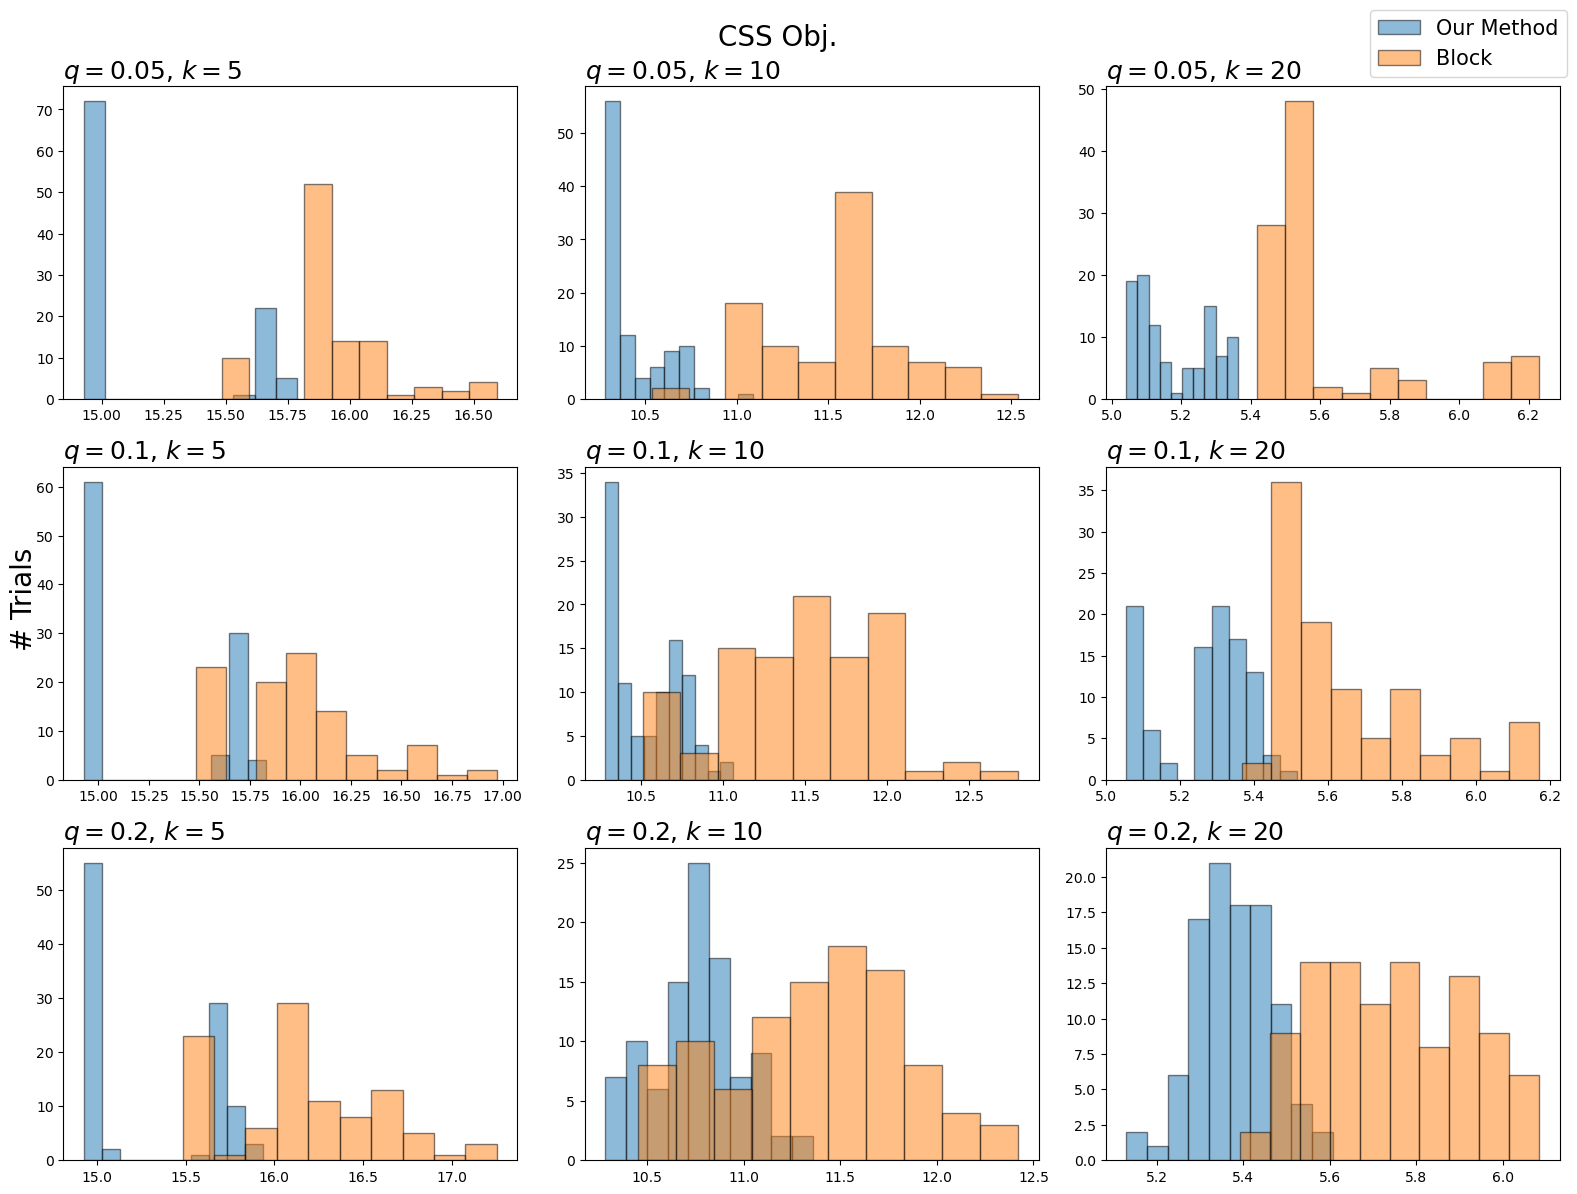

In [90]:

rows, cols = len(qs), len(ks)
keys = list(all_css_results.keys()) # assumes same keys for all_W_hat_results

fig, axes = plt.subplots(rows, cols, figsize=(16, 12), squeeze=False)
for i in range(rows):
    for j in range(cols):
        ell = rows * i + j
        key = keys[ell]
        css_dict = all_css_results[key]
        axes[i,j].hist(css_dict['mask'] * (p-k), label='Our Method', alpha=0.5, edgecolor='black')
        axes[i,j].hist(css_dict['block'] * (p-k), label='BOMP', alpha=0.5, edgecolor='black')
        axes[i,j].set_title(f"$q={key[0]}$, $k={key[1]}$", fontsize=18, loc='left')

fig.legend(labels=['Our Method', 'Block'], prop={'size': 15})   
fig.suptitle("CSS Obj.", fontsize=20)
fig.supylabel("# Trials", fontsize=20)
plt.tight_layout()
plt.savefig("../figures/ozone_css_obj.pdf")
plt.show()


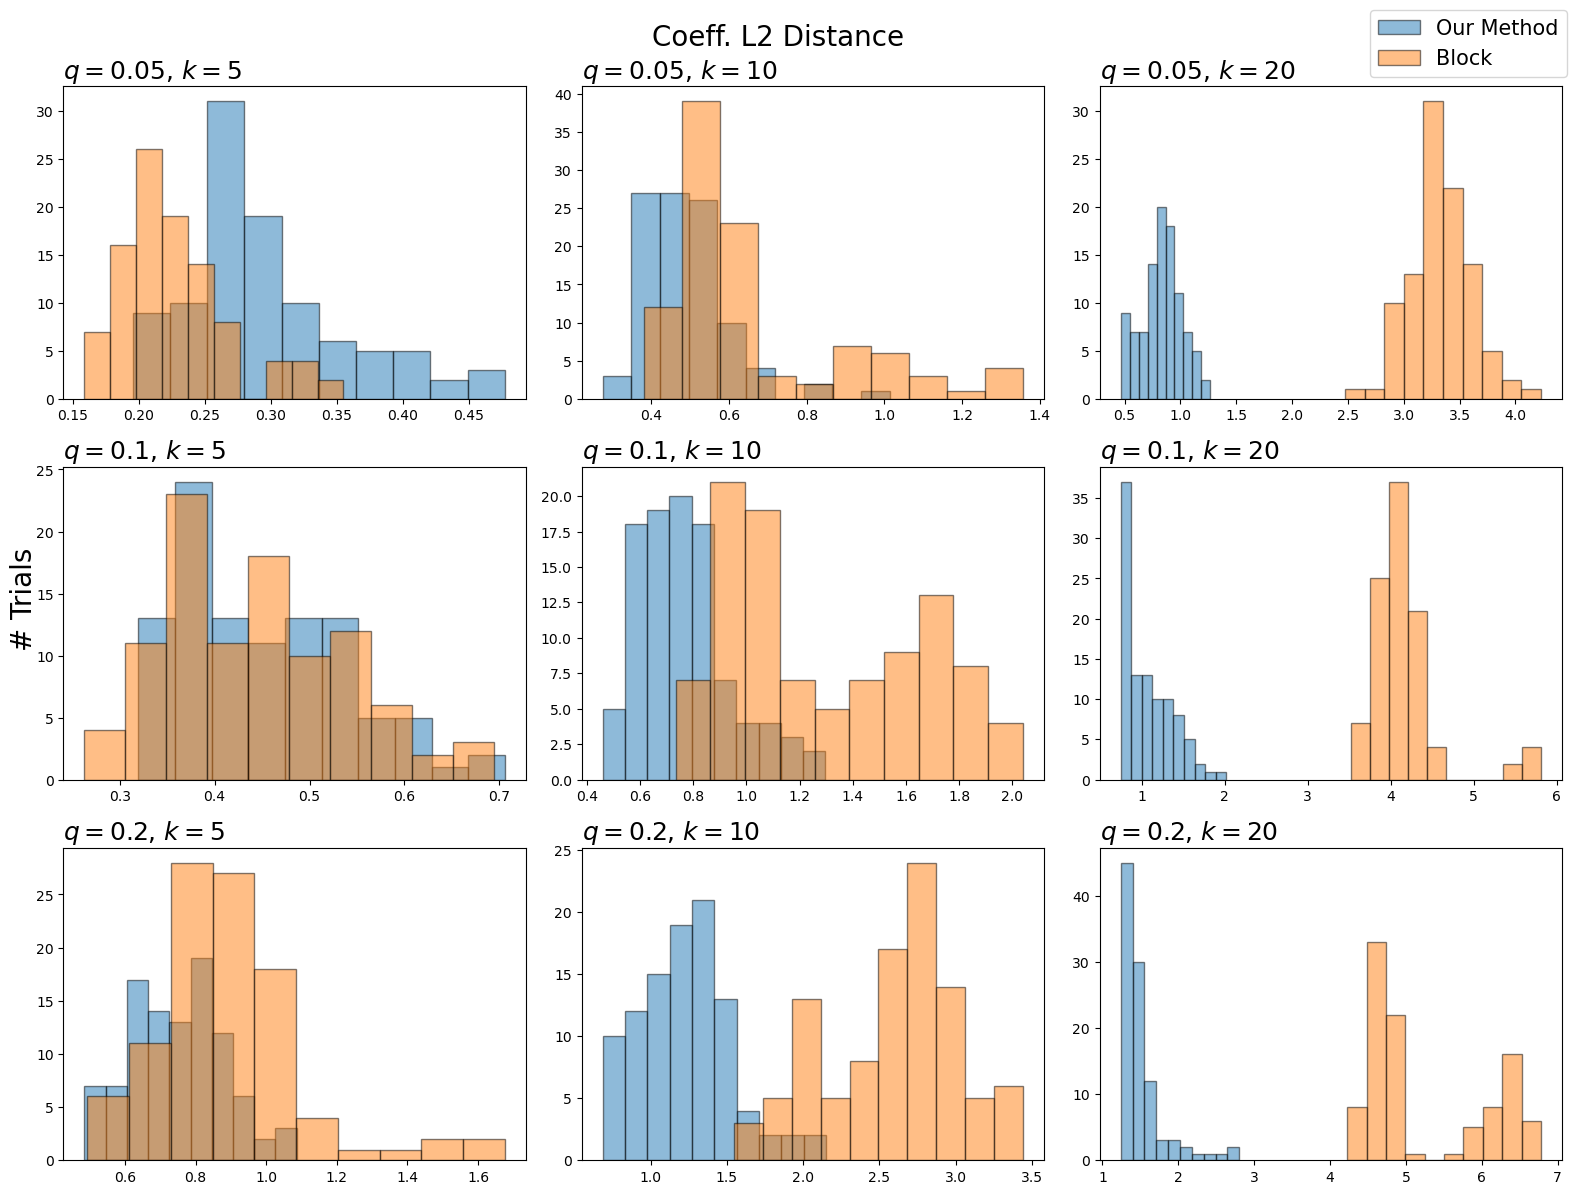

In [89]:
rows, cols = len(qs), len(ks)
keys = list(all_W_hat_results.keys()) 

fig, axes = plt.subplots(rows, cols, figsize=(16, 12), squeeze=False)
for i in range(rows):
    for j in range(cols):
        ell = rows * i + j
        key = keys[ell]
        W_hat_dict = all_W_hat_results[key]
        axes[i,j].hist(W_hat_dict['mask'], label='Our Method', alpha=0.5, edgecolor='black')
        axes[i,j].hist(W_hat_dict['block'], label='BOMP', alpha=0.5, edgecolor='black')
        axes[i,j].set_title(f"$q={key[0]}$, $k={key[1]}$", fontsize=18, loc='left')

fig.legend(labels=['Our Method', 'Block'], prop={'size': 15})   
fig.suptitle("Coeff. L2 Distance", fontsize=20)
fig.supylabel("# Trials", fontsize=20)
plt.tight_layout()
plt.savefig("../figures/ozone_coeff_obj.pdf")
plt.show()

In [12]:
k = 5
q = 0.1
B = 100
X_missing = np.dstack([X for i in range(B)]).transpose(2, 0, 1)
X_missing[np.where(np.random.binomial(1, q, X_missing.shape))] = np.nan

In [10]:
for key in css_results:
    print(key, np.mean(css_results[key]), np.std(css_results[key])/np.sqrt(B))

block 0.30041215958436746 0.0004466275289147791
mask 0.28560783608766077 0.0006126300281674799


In [11]:
for key in W_hat_results:
    print(key, np.mean(W_hat_results[key]),  np.std(W_hat_results[key])/np.sqrt(B))

block 0.2311286008289427 0.004688855194629586
mask 0.29395268234514527 0.007550287339864334
